## Imported Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, AveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
from keras.regularizers import l2
import io
from PIL import Image
from keras.utils import to_categorical
from IPython.display import display,clear_output
from warnings import filterwarnings

### Data Laoding and Preprocessing

In [ ]:
data_dir = "/kaggle/input/brain-tumor-classification-mri/Training"

class_names = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

def load_data(data_directory):
    images = []
    labels = []
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_directory, class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                img_path = os.path.join(class_dir, filename)
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img_array)
                labels.append(class_idx)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Load the data
X, y = load_data(data_dir)

# Normalize the pixel values
X = X / 255.0

# Convert class vectors to binary class matrices
y = to_categorical(y, num_classes=len(class_names))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Data augmentation
data_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Prepare iterators
train_gen = data_gen.flow(X_train, y_train, batch_size=32)
val_gen = data_gen.flow(X_val, y_val, batch_size=32)

## BaseLine Model Training

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax'),
])

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 86528)             0

In [ ]:
# Define a callback to prevent overfitting
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')
]

# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=50,
    validation_data=val_gen,
    validation_steps=len(val_gen),
    callbacks=callbacks
)

Epoch 1/50
72/72 [==============================] - 42s 438ms/step - loss: 1.3678 - accuracy: 0.3587 - val_loss: 1.3240 - val_accuracy: 0.3902
Epoch 2/50
72/72 [==============================] - 29s 398ms/step - loss: 1.1586 - accuracy: 0.4758 - val_loss: 0.9684 - val_accuracy: 0.5976
Epoch 3/50
72/72 [==============================] - 29s 398ms/step - loss: 0.9572 - accuracy: 0.5835 - val_loss: 0.8578 - val_accuracy: 0.6551
Epoch 4/50
72/72 [==============================] - 29s 403ms/step - loss: 0.8805 - accuracy: 0.6283 - val_loss: 0.8920 - val_accuracy: 0.6237
Epoch 5/50
72/72 [==============================] - 29s 398ms/step - loss: 0.8455 - accuracy: 0.6275 - val_loss: 0.8267 - val_accuracy: 0.6341
Epoch 6/50
72/72 [==============================] - 30s 411ms/step - loss: 0.8030 - accuracy: 0.6541 - val_loss: 0.7654 - val_accuracy: 0.6847
Epoch 7/50
72/72 [==============================] - 29s 402ms/step - loss: 0.7716 - accuracy: 0.6754 - val_loss: 0.8013 - val_accuracy: 0.6463

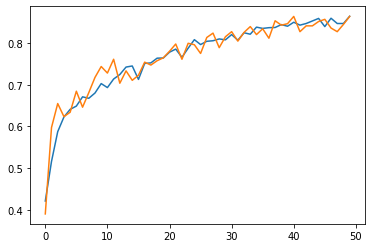

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

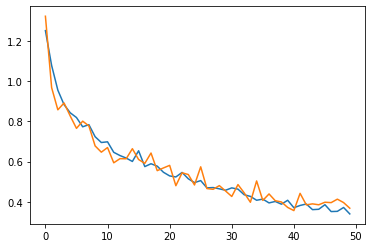

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
# Predict the labels for the training set
y_train_pred = model.predict(X_train)

# Convert the predicted probabilities to class labels
y_train_pred_labels = np.argmax(y_train_pred, axis=1)

# Convert one-hot encoded labels to the actual class labels
y_train_true_labels = np.argmax(y_train, axis=1)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train_true_labels, y_train_pred_labels)
print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

# Predict the labels for the validation set
y_val_pred = model.predict(X_val)

# Convert the predicted probabilities to class labels
y_val_pred_labels = np.argmax(y_val_pred, axis=1)

# Convert one-hot encoded labels to the actual class labels
y_val_true_labels = np.argmax(y_val, axis=1)

# Calculate validation accuracy
val_accuracy = accuracy_score(y_val_true_labels, y_val_pred_labels)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

Training Accuracy: 95.69%
Validation Accuracy: 90.59%


<Figure size 1440x1440 with 0 Axes>

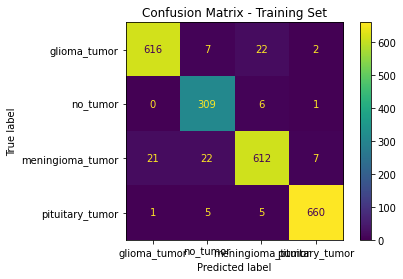

<Figure size 1440x1440 with 0 Axes>

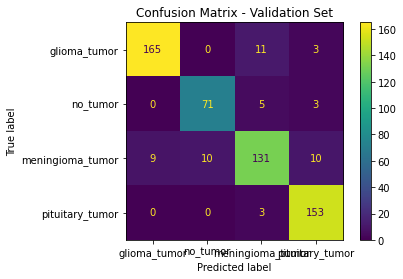

In [ ]:
# Plot the confusion matrix for the training set


cm_train = confusion_matrix(y_train_true_labels, y_train_pred_labels)
plt.figure(figsize=(20, 20))
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=class_names)
disp_train.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix - Training Set')
plt.show()


# Plot the confusion matrix for the validation set
cm_val = confusion_matrix(y_val_true_labels, y_val_pred_labels)
plt.figure(figsize=(20, 20))
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=class_names)
disp_val.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix - Validation Set')
plt.show()


# BaseLine Updated Model

In [ ]:
# Adjusting the learning rate
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model_1_update = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),  # Added dropout layer

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),  # Added dropout layer

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Reduced neurons and added L2 regularization
    Dropout(0.5),

    Dense(len(class_names), activation='softmax'),
])

model_1_update.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model_1_update.summary()

# Define a callback to prevent overfitting
callbacks_1_updated = [
    tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')
]

# Optional: Implement data augmentation here if needed

# Train the model
history_1_updated = model_1_update.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=50,
    validation_data=val_gen,
    validation_steps=len(val_gen),
    callbacks=callbacks
)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_2 (Batch (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 109, 109, 64)      256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 54, 54, 64)       

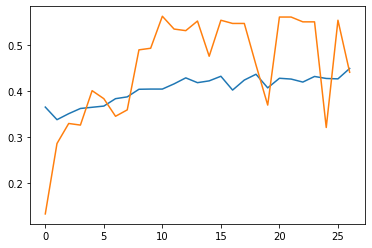

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_1_updated.history['accuracy'])
plt.plot(history_1_updated.history['val_accuracy'])

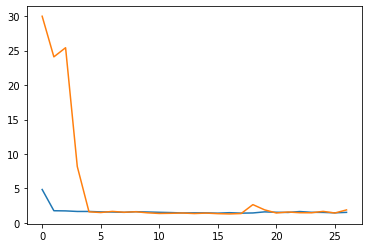

In [ ]:
plt.plot(history_1_updated.history['loss'])
plt.plot(history_1_updated.history['val_loss'])

In [ ]:
# Predict the labels for the training set
y_train_pred_1_updated = model_1_update.predict(X_train)

# Convert the predicted probabilities to class labels
y_train_pred_labels_1_updated = np.argmax(y_train_pred_1_updated, axis=1)

# Convert one-hot encoded labels to the actual class labels
y_train_true_labels = np.argmax(y_train, axis=1)

# Calculate training accuracy
train_accuracy_1_updated = accuracy_score(y_train_true_labels, y_train_pred_labels_1_updated)
print(f'Training Accuracy: {train_accuracy_1_updated * 100:.2f}%')

# Predict the labels for the validation set
y_val_pred_1_updated = model_1.predict(X_val)

# Convert the predicted probabilities to class labels
y_val_pred_labels_1_updated = np.argmax(y_val_pred_1_updated, axis=1)

# Convert one-hot encoded labels to the actual class labels
y_val_true_labels = np.argmax(y_val, axis=1)

# Calculate validation accuracy
val_accuracy_1_updated = accuracy_score(y_val_true_labels, y_val_pred_labels_1_updated)
print(f'Validation Accuracy: {val_accuracy_1_updated * 100:.2f}%')


Training Accuracy: 41.55%
Validation Accuracy: 54.53%


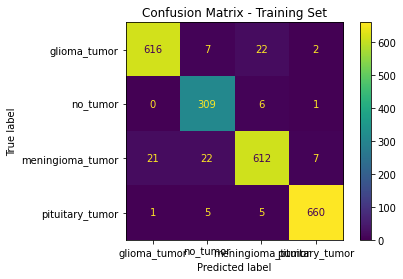

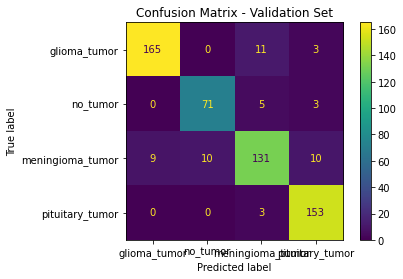

In [ ]:
# Plot the confusion matrix for the training set
cm_train_1_updated = confusion_matrix(y_train_true_labels, y_train_pred_labels_1_updated)
disp_train_1_updated = ConfusionMatrixDisplay(confusion_matrix=cm_train_1_updated, display_labels=class_names)
disp_train.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix - Training Set')
plt.show()

# Plot the confusion matrix for the validation set
cm_val_1_updated = confusion_matrix(y_val_true_labels, y_val_pred_labels_1_updated)
disp_val_1_updated = ConfusionMatrixDisplay(confusion_matrix=cm_val_1_updated, display_labels=class_names)
disp_val.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix - Validation Set')
plt.show()


## Lenet Model

In [ ]:
# Define the LeNet-5 architecture
model_1 = Sequential([
    Conv2D(filters=6, kernel_size=(5, 5), activation='tanh', input_shape=(224, 224, 3)),
    AveragePooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(filters=16, kernel_size=(5, 5), activation='tanh'),
    AveragePooling2D(pool_size=(2, 2), strides=(2, 2)),
    Flatten(),
    Dense(units=120, activation='tanh'),
    Dense(units=84, activation='tanh'),
    Dense(units=len(class_names), activation='softmax')
])

# Compile the model
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_1.summary()

# Define a callback for early stopping
callbacks_1 = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')
]

# Train the model
history_1 = model_1.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=50,
    validation_data=val_gen,
    validation_steps=len(val_gen),
    callbacks=callbacks
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 220, 220, 6)       456       
_________________________________________________________________
average_pooling2d_2 (Average (None, 110, 110, 6)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 106, 106, 16)      2416      
_________________________________________________________________
average_pooling2d_3 (Average (None, 53, 53, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 44944)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 120)               5393400   
_________________________________________________________________
dense_7 (Dense)              (None, 84)               

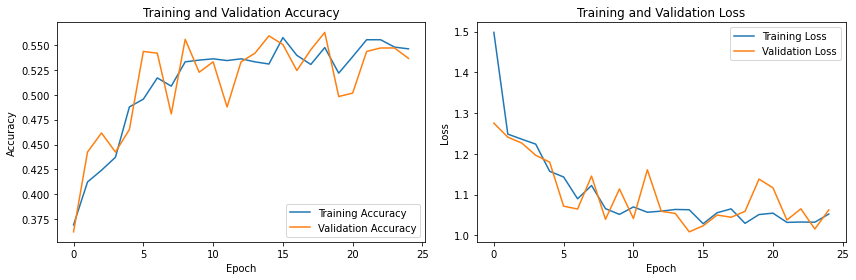

In [ ]:
# Plot the training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Predict the labels for the training set
y_train_pred_1 = model_1.predict(X_train)

# Convert the predicted probabilities to class labels
y_train_pred_labels_1 = np.argmax(y_train_pred_1, axis=1)

# Convert one-hot encoded labels to the actual class labels
y_train_true_labels = np.argmax(y_train, axis=1)

# Calculate training accuracy
train_accuracy_1 = accuracy_score(y_train_true_labels, y_train_pred_labels_1)
print(f'Training Accuracy: {train_accuracy_1 * 100:.2f}%')

# Predict the labels for the validation set
y_val_pred_1 = model_1.predict(X_val)

# Convert the predicted probabilities to class labels
y_val_pred_labels_1 = np.argmax(y_val_pred_1, axis=1)

# Convert one-hot encoded labels to the actual class labels
y_val_true_labels = np.argmax(y_val, axis=1)

# Calculate validation accuracy
val_accuracy_1 = accuracy_score(y_val_true_labels, y_val_pred_labels_1)
print(f'Validation Accuracy: {val_accuracy_1 * 100:.2f}%')


Training Accuracy: 57.97%
Validation Accuracy: 54.53%


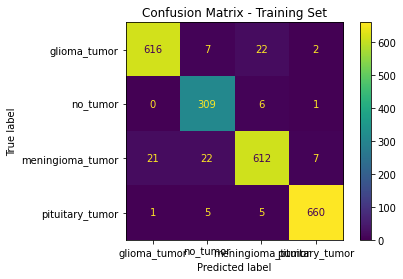

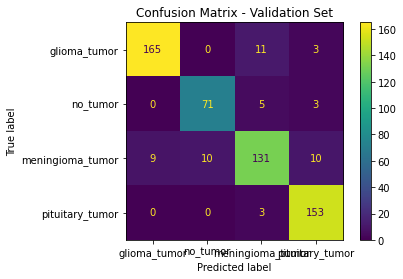

In [ ]:
# Plot the confusion matrix for the training set
cm_train_1 = confusion_matrix(y_train_true_labels, y_train_pred_labels_1)
disp_train_1 = ConfusionMatrixDisplay(confusion_matrix=cm_train_1, display_labels=class_names)
disp_train.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix - Training Set')
plt.show()

# Plot the confusion matrix for the validation set
cm_val_1 = confusion_matrix(y_val_true_labels, y_val_pred_labels_1)
disp_val_1 = ConfusionMatrixDisplay(confusion_matrix=cm_val_1, display_labels=class_names)
disp_val.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix - Validation Set')
plt.show()


## Alexnet Model

In [ ]:
model_2 = Sequential([
    Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

# Compile the model
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_2.summary()

# Define a callback for early stopping
callbacks_2 = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')
]

# Train the model
history_2 = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=100,  # AlexNet was trained for 90 epochs, but you might need fewer or more depending on your dataset
    validation_data=val_gen,
    validation_steps=len(val_gen),
    callbacks=callbacks
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 54, 54, 96)        384       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 26, 26, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 256)       1024      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 12, 12, 384)      

<function matplotlib.pyplot.legend(*args, **kwargs)>

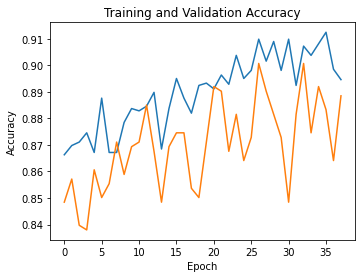

In [ ]:
# Plot the training history
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend

In [ ]:
# Predict the labels for the training set
y_train_pred_2 = model_2.predict(X_train)

# Convert the predicted probabilities to class labels
y_train_pred_labels_2 = np.argmax(y_train_pred_2, axis=1)

# Convert one-hot encoded labels to the actual class labels
y_train_true_labels = np.argmax(y_train, axis=1)

# Calculate training accuracy
train_accuracy_2 = accuracy_score(y_train_true_labels, y_train_pred_labels_2)
print(f'Training Accuracy: {train_accuracy_2 * 100:.2f}%')

# Predict the labels for the validation set
y_val_pred_2 = model_2.predict(X_val)

# Convert the predicted probabilities to class labels
y_val_pred_labels_2 = np.argmax(y_val_pred_2, axis=1)

# Convert one-hot encoded labels to the actual class labels
y_val_true_labels_2 = np.argmax(y_val, axis=1)

# Calculate validation accuracy
val_accuracy_2 = accuracy_score(y_val_true_labels, y_val_pred_labels_2)
print(f'Validation Accuracy: {val_accuracy_2 * 100:.2f}%')


Training Accuracy: 28.18%
Validation Accuracy: 31.18%


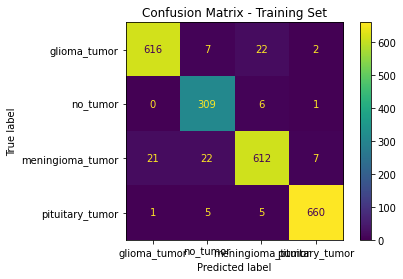

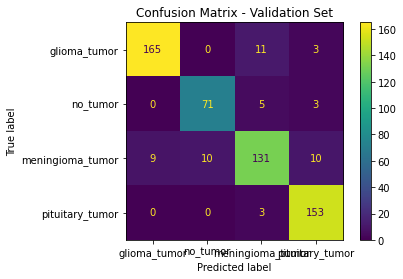

In [ ]:
# Plot the confusion matrix for the training set
cm_train_2 = confusion_matrix(y_train_true_labels, y_train_pred_labels_2)
disp_train_2 = ConfusionMatrixDisplay(confusion_matrix=cm_train_2, display_labels=class_names)
disp_train.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix - Training Set')
plt.show()

# Plot the confusion matrix for the validation set
cm_val_2 = confusion_matrix(y_val_true_labels, y_val_pred_labels_2)
disp_val_2 = ConfusionMatrixDisplay(confusion_matrix=cm_val_2, display_labels=class_names)
disp_val.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix - Validation Set')
plt.show()
